In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
##===
# Select state we want to predict
# New York , California , Florida , Texas
STATE = 'California'

WEIGHTDECAY = 0
TRAIN = True
seq_length = 21
N_EPOCHS = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
##===

#### Model Config ===
# channel_config = np.array([[1,64,128],[128,64,64],[64,32,1]])
#channel_config = np.array([[1,7,14],[14,7,7],[7,4,1]])
channel_config = np.array([[1,7,14],[14,21,14],[14,7,1]])

## Data frame Format

### Import Data from CSV file

In [4]:
#df = pd.read_excel("./drive/Shareddrives/BI&A/Data/Cleaned Data.xlsx")
df = pd.read_csv('Cleaned_data.csv')

In [5]:
df.head()

,date,state,fips,cases,daily_cases,deaths,daily_deaths,total_vaccinations,total_distributed,daily_distributed,total_people_vaccinated,daily_people_vaccinated,total_people_fully_vaccinated,daily_people_fully_vaccinated,daily_vaccinations,mobility_composite
0,3/13/2021,Alabama,1,503305,594,10327,28,1288242,1918560.0,80160.0,841394.0,24976.0,492755.0,20430.0,"26,935",-1.013041
1,3/12/2021,Alabama,1,502711,448,10299,25,1249205,1838400.0,22170.0,816418.0,25554.0,472325.0,19579.0,"26,375",-1.013041
2,3/11/2021,Alabama,1,502263,865,10274,52,1209802,1816230.0,40570.0,790864.0,22362.0,452746.0,17728.0,"25,376",-1.013041
3,3/10/2021,Alabama,1,501398,782,10222,36,1173820,1775660.0,86610.0,768502.0,21234.0,435018.0,14935.0,"24,827",-1.013041
4,3/9/2021,Alabama,1,500616,524,10186,38,1140984,1689050.0,60700.0,747268.0,14301.0,420083.0,10146.0,"24,118",-1.013041


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20618 entries, 0 to 20617
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           20618 non-null  object 
 1   state                          20618 non-null  object 
 2   fips                           20618 non-null  int64  
 3   cases                          20618 non-null  int64  
 4   daily_cases                    20618 non-null  int64  
 5   deaths                         20618 non-null  int64  
 6   daily_deaths                   20618 non-null  int64  
 7   total_vaccinations             3801 non-null   object 
 8   total_distributed              3801 non-null   float64
 9   daily_distributed              3801 non-null   float64
 10  total_people_vaccinated        3801 non-null   float64
 11  daily_people_vaccinated        3801 non-null   float64
 12  total_people_fully_vaccinated  3801 non-null  

In [7]:
df = df.drop(labels=['cases', 'deaths', 'total_vaccinations', 'total_distributed', 'total_people_vaccinated', 'total_people_fully_vaccinated'], axis=1)
df.head()

,date,state,fips,daily_cases,daily_deaths,daily_distributed,daily_people_vaccinated,daily_people_fully_vaccinated,daily_vaccinations,mobility_composite
0,3/13/2021,Alabama,1,594,28,80160.0,24976.0,20430.0,"26,935",-1.013041
1,3/12/2021,Alabama,1,448,25,22170.0,25554.0,19579.0,"26,375",-1.013041
2,3/11/2021,Alabama,1,865,52,40570.0,22362.0,17728.0,"25,376",-1.013041
3,3/10/2021,Alabama,1,782,36,86610.0,21234.0,14935.0,"24,827",-1.013041
4,3/9/2021,Alabama,1,524,38,60700.0,14301.0,10146.0,"24,118",-1.013041


In [8]:
df['state'].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Guam', 'Hawaii', 'Idaho', 'Illinois',
       'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine',
       'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Northern Mariana Islands',
       'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virgin Islands', 'Virginia',
       'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

In [9]:
# Set date to be datetime format and sort by date and fips
df['date'] = pd.to_datetime(df.date)
df = df.sort_values(by=['date', 'fips'], axis=0, ascending=True)
df

,date,state,fips,daily_cases,daily_deaths,daily_distributed,daily_people_vaccinated,daily_people_fully_vaccinated,daily_vaccinations,mobility_composite
19484,2020-01-21,Washington,53,1,0,NaN,NaN,NaN,NaN,NaN
19483,2020-01-22,Washington,53,0,0,NaN,NaN,NaN,NaN,NaN
19482,2020-01-23,Washington,53,0,0,NaN,NaN,NaN,NaN,NaN
5684,2020-01-24,Illinois,17,1,0,NaN,NaN,NaN,NaN,NaN
19481,2020-01-24,Washington,53,0,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
20250,2021-03-13,Wyoming,56,0,0,0.0,4086.0,2945.0,"4,085",0.000000
4168,2021-03-13,Guam,66,1,0,0.0,226.0,1440.0,"1,272",-5.361115
13475,2021-03-13,Northern Mariana Islands,69,1,0,0.0,230.0,163.0,246,NaN
15319,2021-03-13,Puerto Rico,72,235,0,19550.0,32455.0,20400.0,"19,615",0.000000


In [10]:
df_clean = df[df.state == STATE]
df_clean = df_clean.set_index('date')
df_clean

,state,fips,daily_cases,daily_deaths,daily_distributed,daily_people_vaccinated,daily_people_fully_vaccinated,daily_vaccinations,mobility_composite
date,,,,,,,,,
2020-01-25,California,6,1,0,NaN,NaN,NaN,NaN,NaN
2020-01-26,California,6,1,0,NaN,NaN,NaN,NaN,NaN
2020-01-27,California,6,0,0,NaN,NaN,NaN,NaN,NaN
2020-01-28,California,6,0,0,NaN,NaN,NaN,NaN,NaN
2020-01-29,California,6,0,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-03-09,California,6,4131,243,1162100.0,82138.0,37820.0,"204,065",-32.197826
2021-03-10,California,6,3464,257,254140.0,96767.0,40388.0,"190,191",-32.197826
2021-03-11,California,6,3560,255,424380.0,103215.0,56316.0,"194,328",-32.197826


In [11]:
rmlabels=['state', 'fips', 'daily_deaths', 'daily_distributed','daily_people_vaccinated', 'daily_people_fully_vaccinated',
          'daily_vaccinations', 'mobility_composite']
df_clean = df_clean.drop(labels=rmlabels, axis=1)
df_clean = df_clean.iloc[df_clean.shape[0]-378:]
df_clean.shape

(378, 1)

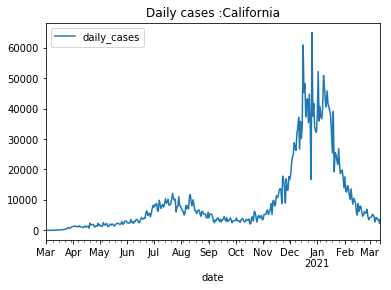

In [12]:
df_clean.plot(title=f"Daily cases :{STATE}")

In [13]:
df.head()

,date,state,fips,daily_cases,daily_deaths,daily_distributed,daily_people_vaccinated,daily_people_fully_vaccinated,daily_vaccinations,mobility_composite
19484,2020-01-21,Washington,53,1,0,NaN,NaN,NaN,NaN,NaN
19483,2020-01-22,Washington,53,0,0,NaN,NaN,NaN,NaN,NaN
19482,2020-01-23,Washington,53,0,0,NaN,NaN,NaN,NaN,NaN
5684,2020-01-24,Illinois,17,1,0,NaN,NaN,NaN,NaN,NaN
19481,2020-01-24,Washington,53,0,0,NaN,NaN,NaN,NaN,NaN


In [14]:
df_state = df[df.state == STATE]

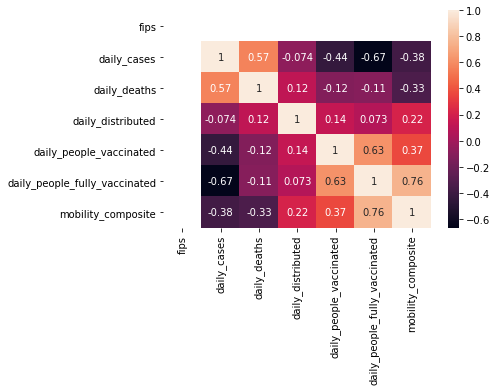

In [15]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = df_state.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

### select the high correlation to be our factors

- daily death
- daily people vacinated 
- daily_distibuted  
- daily case 

In [16]:
df_state.columns

Index(['date', 'state', 'fips', 'daily_cases', 'daily_deaths',
       'daily_distributed', 'daily_people_vaccinated',
       'daily_people_fully_vaccinated', 'daily_vaccinations',
       'mobility_composite'],
      dtype='object')

In [17]:
df_state = df_state.set_index('date') 

In [18]:
df_state

,state,fips,daily_cases,daily_deaths,daily_distributed,daily_people_vaccinated,daily_people_fully_vaccinated,daily_vaccinations,mobility_composite
date,,,,,,,,,
2020-01-25,California,6,1,0,NaN,NaN,NaN,NaN,NaN
2020-01-26,California,6,1,0,NaN,NaN,NaN,NaN,NaN
2020-01-27,California,6,0,0,NaN,NaN,NaN,NaN,NaN
2020-01-28,California,6,0,0,NaN,NaN,NaN,NaN,NaN
2020-01-29,California,6,0,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-03-09,California,6,4131,243,1162100.0,82138.0,37820.0,"204,065",-32.197826
2021-03-10,California,6,3464,257,254140.0,96767.0,40388.0,"190,191",-32.197826
2021-03-11,California,6,3560,255,424380.0,103215.0,56316.0,"194,328",-32.197826


In [19]:
df_state = df_state.drop(['state', 'fips',
       'daily_people_vaccinated',
       'daily_people_fully_vaccinated',
       'mobility_composite'], axis=1)

In [20]:
df_state.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 414 entries, 2020-01-25 to 2021-03-13
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   daily_cases         414 non-null    int64  
 1   daily_deaths        414 non-null    int64  
 2   daily_distributed   72 non-null     float64
 3   daily_vaccinations  72 non-null     object 
dtypes: float64(1), int64(2), object(1)
memory usage: 16.2+ KB


In [21]:
df_state_clean = df_state.dropna()

In [22]:
df_state_clean = df_state_clean.replace(',','', regex=True)

In [23]:
df_state_clean.shape

(72, 4)

In [24]:
df_state_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2021-01-01 to 2021-03-13
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   daily_cases         72 non-null     int64  
 1   daily_deaths        72 non-null     int64  
 2   daily_distributed   72 non-null     float64
 3   daily_vaccinations  72 non-null     object 
dtypes: float64(1), int64(2), object(1)
memory usage: 2.8+ KB


In [29]:
df_state.tail()

,daily_cases,daily_deaths,daily_distributed,daily_vaccinations
date,,,,
2021-03-09,4131,243,1162100.0,"204,065"
2021-03-10,3464,257,254140.0,"190,191"
2021-03-11,3560,255,424380.0,"194,328"
2021-03-12,2304,204,331560.0,"193,794"
2021-03-13,3741,1013,318720.0,"209,548"


In [32]:
df_state_daily_cases = df_state['daily_cases'].values

(414,)

## DATA Shape
- (batch_size,data point,channel)

### For CNN shape
- Shape:
        Input:(batch_size,channel, data point)
        

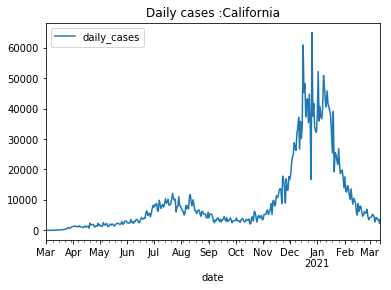

In [26]:
df_clean.plot(title=f"Daily cases :{STATE}")

In [50]:
X = df_state_daily_cases # X -> daily cases
size = int(len(X) * 0.66) 
train, test = X[0:size], X[size:len(X)]
history = [float(x) for x in train]
predictions = []

In [52]:
test.shape

(141,)

In [54]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

for t in range(90):#len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(yhat)
    #print('predicted=%f, expected=%f' % (yhat, obs))
#error = mean_squared_error(test, predictions[1:])
#print('Test MSE: %.3f' % error)
# plot


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


NameError: name 'error' is not defined

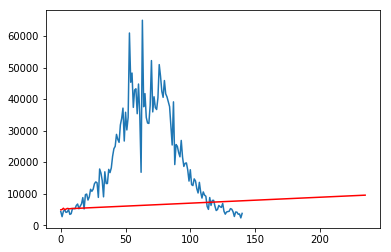

In [55]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()